# Mie Scattering of a Lossless Dielectric Sphere

A common reference calculation in computational electromagnetics for which an analytical solution is known is [Mie scattering](https://en.wikipedia.org/wiki/Mie_scattering) which involves computing the [scattering efficiency](http://www.thermopedia.com/content/956/) of a single, homogeneous sphere given an incident planewave. The scattered power of any object (absorbing or non) can be computed by surrounding it with a *closed* [DFT flux](https://meep.readthedocs.io/en/latest/Python_User_Interface/#flux-spectra) box (its size and orientation are irrelevant because of Poynting's theorem) and performing two simulations: (1) a normalization run involving an empty cell to save the incident fields from the source and (2) the scattering run with the object but first subtracting the incident fields in order to obtain just the scattered fields. This approach has already been described in [Transmittance Spectrum of a Waveguide Bend](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics#transmittance-spectrum-of-a-waveguide-bend).

The scattering cross section is the scattered power in all directions divided by the incident intensity. The scattering efficiency, a dimensionless quantity, is the ratio of the scattering cross section to the cross sectional area of the sphere. In this demonstration, the sphere is a lossless dielectric with wavelength-independent refractive index of 2.0. This way, [subpixel smoothing](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing) can improve accuracy at low resolutions which is important for reducing the size of this 3d simulation. The source is an $E_z$-polarized, planewave pulse (its `size` parameter fills the *entire* cell in 2d) spanning the broadband wavelength spectrum of 10% to 50% the circumference of the sphere. There is one subtlety: since the [planewave source extends into the PML](https://meep.readthedocs.io/en/latest/Perfectly_Matched_Layer/#planewave-sources-extending-into-pml) which surrounds the cell on all sides, `is_integrated=True` must be specified in the source object definition. A `k_point` of zero specifying periodic boundary conditions is necessary in order for the source to be infinitely extended. Also, given the [symmetry of the fields and the structure](https://meep.readthedocs.io/en/latest/Exploiting_Symmetry), two mirror symmery planes can be used to reduce the cell size by a factor of four. The simulation results are validated by comparing with the analytic theory obtained from the [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/) module (which you will have to install in order to run the script below).

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os

keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = params["bumpData"]

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

frq = params["omega"]/(2*np.pi)
wvl = 1 / frq

pml_layers = [mp.PML(thickness=pml_thickness)] 

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=frq, fwidth=1, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size[0], cell_size[1], 0),
        component=component
    )]

def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box_x1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box_x2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box_y1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box_y2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box_z1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box_z2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.run(until_after_sources=60)

    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    box_z1_data = sim.get_flux_data(box_z1)
    box_z2_data = sim.get_flux_data(box_z2)

    box_x1_flux0 = mp.get_fluxes(box_x1)
    sim.reset_meep()

    # Structured simulation (with bumps)
    def material_function(p):
        z_surface = sum(
            b["height"] * np.exp(-((p.x - b["x0"])**2 + (p.y - b["y0"])**2) / (2 * b["sigma"]**2))
            for b in bumps
        )
        return substrate if p.z < z_surface else mp.air

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box_x1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box_x2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box_y1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box_y2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box_z1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box_z2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    sim.load_minus_flux_data(box_z1, box_z1_data)
    sim.load_minus_flux_data(box_z2, box_z2_data)

    sim.run(until_after_sources=60) # maybe 20 is too little? 

    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    box_z1_flux = mp.get_fluxes(box_z1)
    box_z2_flux = mp.get_fluxes(box_z2)

    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
        + np.asarray(box_z1_flux)
        - np.asarray(box_z2_flux)
    )
    # Normalize by incident flux density (assuming monitor area = monitor_size²)
    intensity = np.asarray(box_x1_flux0) / (monitor_size)**2
    scatt_cross_section = np.divide(scatt_flux, intensity)
    # Meep flux convention: power leaving the box is positive
    scatt_eff = scatt_cross_section * -1 / (np.pi * 1**2) # r=1

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux)[0],
        "X2": np.asarray(box_x2_flux)[0],
        "Y1": np.asarray(box_y1_flux)[0],
        "Y2": np.asarray(box_y2_flux)[0],
        "Z1": np.asarray(box_z1_flux)[0],
        "Z2": np.asarray(box_z2_flux)[0],
        "scatt_total": scatt_flux[0],
    }


    return scatt_eff, scatt_flux_components

scatt_eff_list = []
flux_results = []

for beta in betas:
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_ex = make_source(mp.Ex)
    sources_ey = make_source(mp.Ey)

    Qx, flux_ex = run_meep_simulation(sources_ex)
    Qy, flux_ey = run_meep_simulation(sources_ey)

    Q_beta = cos2 * Qx + sin2 * Qy
    scatt_eff_list.append(Q_beta)

    # Combine flux components manually
    flux_combined = {
        "beta": np.degrees(beta),
        "X1": cos2 * flux_ex["X1"] + sin2 * flux_ey["X1"],
        "X2": cos2 * flux_ex["X2"] + sin2 * flux_ey["X2"],
        "Y1": cos2 * flux_ex["Y1"] + sin2 * flux_ey["Y1"],
        "Y2": cos2 * flux_ex["Y2"] + sin2 * flux_ey["Y2"],
        "Z1": cos2 * flux_ex["Z1"] + sin2 * flux_ey["Z1"],
        "Z2": cos2 * flux_ex["Z2"] + sin2 * flux_ey["Z2"],
        "scatt_total": cos2 * flux_ex["scatt_total"] + sin2 * flux_ey["scatt_total"]
    }

    flux_results.append(flux_combined)




beta = 0.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.0060389 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 0.525707 s
-----------
Meep progress: 6.15/70.0 = 8.8% done in 4.0s, 41.6s to go
on time step 123 (time=6.15), 0.0325516 s/step
Meep progress: 16.8/70.0 = 24.0% done in 8.0s, 25.4s to go
on time step 336 (time=16.8), 0.0188414 s/step
Meep progress: 25.6/70.0 = 36.6% done in 12.0s, 20.9s to go
on time step 512 (time=25.6), 0.0227443 s/step
Meep progress: 35.35/70.0 = 50.5% done in 16.1s, 15.7s to go
on time step 707 (time=35.35), 0.0206566 s/step
Meep progress: 41.050000000000004/70.0 = 58.6% done in 20.1s, 14.2s to go
on time step 821 (time=41.05), 0.0353981 s/step
Meep progress: 48.5/70.0 = 69.3% done in 24.1s, 10.7s to go
on time step 970 (time=48.5), 0.0269078 s/step
Meep progress: 54.1/70.0 = 77.3% done in 28.1s, 8.3s to go
on time step 1082 (time=54.1), 0.0358002 s/step
Meep progress: 58.800

KeyboardInterrupt: 

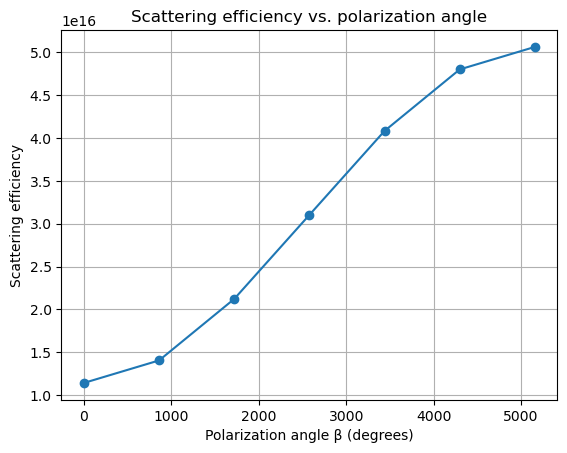

In [54]:
plt.plot([np.degrees(b) for b in betas], scatt_eff_list, marker='o')
plt.xlabel("Polarization angle β (degrees)")
plt.ylabel("Scattering efficiency")
plt.grid(True)
plt.title("Scattering efficiency vs. polarization angle")
plt.show()


In [55]:
from tabulate import tabulate

def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

table_data = [
    [f"{scalar(row['beta']):.1f}°",
     f"{scalar(row['X1']):.5f}",
     f"{scalar(row['X2']):.5f}",
     f"{scalar(row['Y1']):.5f}",
     f"{scalar(row['Y2']):.5f}",
     f"{scalar(row['Z1']):.5f}",
     f"{scalar(row['Z2']):.5f}",
     f"{scalar(row['scatt_total']):.5f}"]
    for row in flux_results
]

headers = ["β (°)", "X1 (−x)", "X2 (+x)", "Y1 (−y)", "Y2 (+y)", "Z1 (−z)", "Z2 (+z)", "Scatt. Total"]
print(tabulate(table_data, headers=headers, tablefmt="github"))


| β (°)   |   X1 (−x) |   X2 (+x) |   Y1 (−y) |   Y2 (+y) |   Z1 (−z) |   Z2 (+z) |   Scatt. Total |
|---------|-----------|-----------|-----------|-----------|-----------|-----------|----------------|
| 0.0°    |  -0.00014 |  -9e-05   |  -0.00139 |   0.00038 |  -0.07072 |   0.00877 |       -0.08131 |
| 15.0°   |  -0.00021 |   1e-05   |  -0.00129 |   0.00037 |  -0.07072 |   0.00876 |       -0.08136 |
| 30.0°   |  -0.00039 |   0.0003  |  -0.00101 |   0.00035 |  -0.07071 |   0.00874 |       -0.08149 |
| 45.0°   |  -0.00063 |   0.00069 |  -0.00063 |   0.00031 |  -0.0707  |   0.00871 |       -0.08167 |
| 60.0°   |  -0.00088 |   0.00108 |  -0.00025 |   0.00028 |  -0.07069 |   0.00868 |       -0.08185 |
| 75.0°   |  -0.00106 |   0.00136 |   3e-05   |   0.00025 |  -0.07068 |   0.00866 |       -0.08198 |
| 90.0°   |  -0.00112 |   0.00147 |   0.00013 |   0.00024 |  -0.07067 |   0.00865 |       -0.08203 |


In [56]:
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

for entry in flux_results:
    print(f"\n--- β = {scalar(entry['beta']):.1f}° ---")
    print(f"X1 (−x): {scalar(entry['X1']):.5f}")
    print(f"X2 (+x): {scalar(entry['X2']):.5f}")
    print(f"Y1 (−y): {scalar(entry['Y1']):.5f}")
    print(f"Y2 (+y): {scalar(entry['Y2']):.5f}")
    print(f"Z1 (−z): {scalar(entry['Z1']):.5f}")
    print(f"Z2 (+z): {scalar(entry['Z2']):.5f}")
    print(f"Scattered Total: {scalar(entry['scatt_total']):.5f}")



--- β = 0.0° ---
X1 (−x): -0.00014
X2 (+x): -0.00009
Y1 (−y): -0.00139
Y2 (+y): 0.00038
Z1 (−z): -0.07072
Z2 (+z): 0.00877
Scattered Total: -0.08131

--- β = 15.0° ---
X1 (−x): -0.00021
X2 (+x): 0.00001
Y1 (−y): -0.00129
Y2 (+y): 0.00037
Z1 (−z): -0.07072
Z2 (+z): 0.00876
Scattered Total: -0.08136

--- β = 30.0° ---
X1 (−x): -0.00039
X2 (+x): 0.00030
Y1 (−y): -0.00101
Y2 (+y): 0.00035
Z1 (−z): -0.07071
Z2 (+z): 0.00874
Scattered Total: -0.08149

--- β = 45.0° ---
X1 (−x): -0.00063
X2 (+x): 0.00069
Y1 (−y): -0.00063
Y2 (+y): 0.00031
Z1 (−z): -0.07070
Z2 (+z): 0.00871
Scattered Total: -0.08167

--- β = 60.0° ---
X1 (−x): -0.00088
X2 (+x): 0.00108
Y1 (−y): -0.00025
Y2 (+y): 0.00028
Z1 (−z): -0.07069
Z2 (+z): 0.00868
Scattered Total: -0.08185

--- β = 75.0° ---
X1 (−x): -0.00106
X2 (+x): 0.00136
Y1 (−y): 0.00003
Y2 (+y): 0.00025
Z1 (−z): -0.07068
Z2 (+z): 0.00866
Scattered Total: -0.08198

--- β = 90.0° ---
X1 (−x): -0.00112
X2 (+x): 0.00147
Y1 (−y): 0.00013
Y2 (+y): 0.00024
Z1 (−z): -0.0

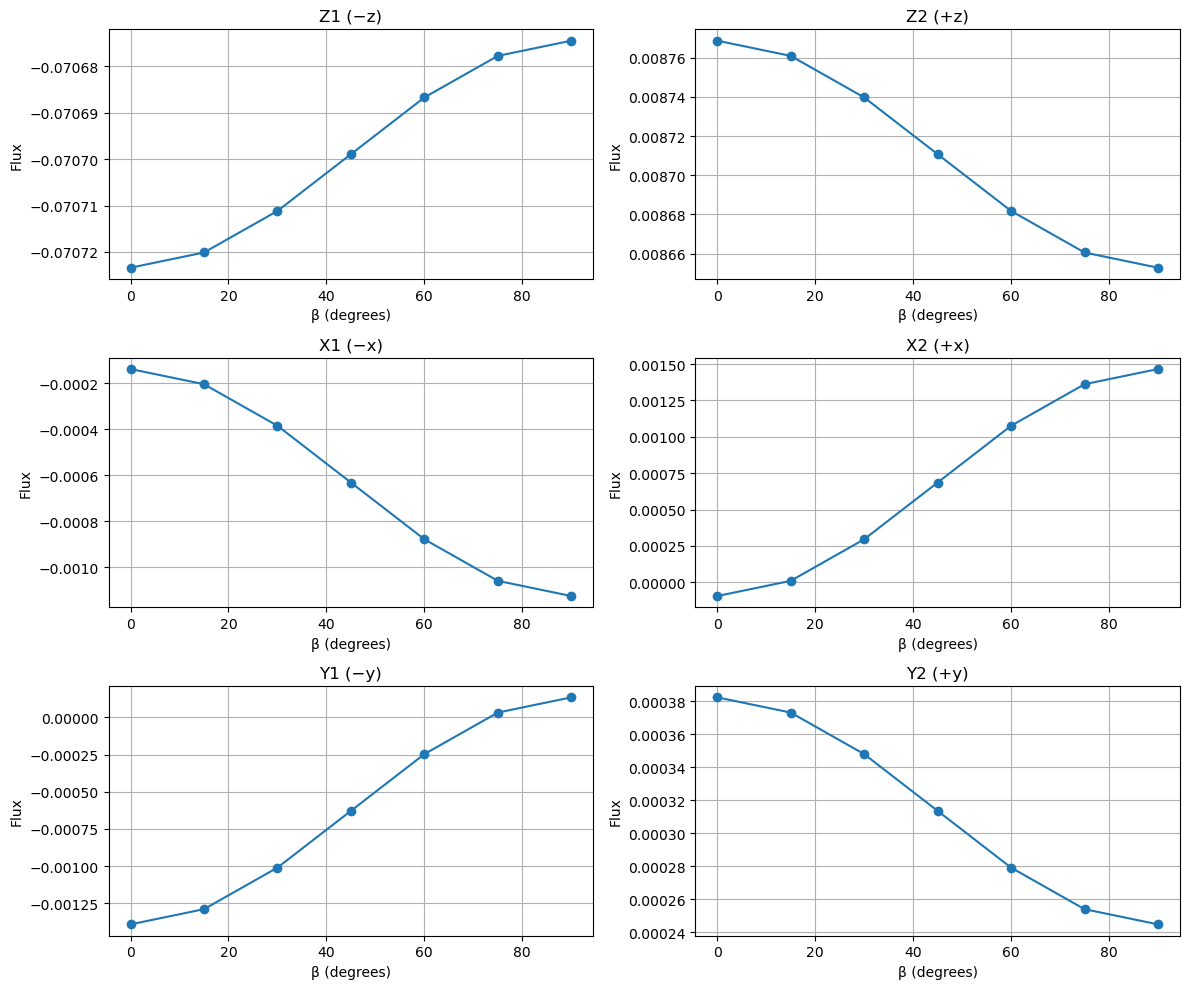

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

# Extract data
betas = [scalar(entry['beta']) for entry in flux_results]
Z1 = [scalar(entry['Z1']) for entry in flux_results]
Z2 = [scalar(entry['Z2']) for entry in flux_results]
X1 = [scalar(entry['X1']) for entry in flux_results]
X2 = [scalar(entry['X2']) for entry in flux_results]
Y1 = [scalar(entry['Y1']) for entry in flux_results]
Y2 = [scalar(entry['Y2']) for entry in flux_results]


# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each component
labels = ['Z1 (−z)', 'Z2 (+z)', 'X1 (−x)', 'X2 (+x)', 'Y1 (−y)', 'Y2 (+y)']
values = [Z1, Z2, X1, X2, Y1, Y2]

for i, (label, val) in enumerate(zip(labels, values)):
    axs[i].plot(betas, val, marker='o')
    axs[i].set_title(label)
    axs[i].set_xlabel("β (degrees)")
    axs[i].set_ylabel("Flux")
    axs[i].grid(True)

# Hide unused subplot if any
if len(axs) > len(labels):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


The incident intensity (`intensity`) is the flux in one of the six monitor planes (the one closest to and facing the planewave source propagating in the $x$ direction) divided by its area. This is why the six sides of the flux box are defined separately. (Otherwise, the entire box could have been defined as a single flux object with different weights ±1 for each side.) The scattered power is multiplied by -1 since it is the *outgoing* power (a positive quantity) rather than the incoming power as defined by the orientation of the flux box. Note that because of the linear $E_z$ polarization of the source, the flux through the $y$ and $z$ planes will *not* be the same. A circularly-polarized source would have produced equal flux in these two monitor planes. The runtime of the scattering run is chosen to be sufficiently long to ensure that the Fourier-transformed fields have [converged](https://meep.readthedocs.io/en/latest/FAQ/checking-convergence).